### Pooled off period detection

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    # + subjects.nsd.ratNday2
    # + subjects.nsd.ratSday2
    # # + subjects.nsd.ratRday1
    # + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1

)

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [ ]:
from neuropy.analyses import detect_local_sleep_epochs
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    period = [post[0],post[0]+5*3600] 
    mua =sess.mua.time_slice(*period)
    smth_mua = mua.get_smoothed(sigma=0.02)

    off = detect_local_sleep_epochs(smth_mua)
    off.save(sess.filePrefix.with_suffix('.off'))

### Occurence rate during sleep deprivation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
)

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [ ]:
off_rate_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5* 3600]
    off = sess.off.starts

    binsz = 3600
    n_bins = np.diff(period)/ binsz
    sd_bin = np.arange(n_bins + 1) * binsz + period[0]
    hist_off = np.histogram(off, bins=sd_bin)[0]

    off_rate_df = off_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_off / binsz,
                "Zt": (sd_bin[:-1] - sd_bin[0]) / 3600 +1,
                "sub": sub,
                "grp": sess.tag,
            }
        ),
        ignore_index=True,
    )

# subjects.GroupData().save(pbe_rate_df,'off_rate')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd",'nsd']):
    df = off_rate_df[off_rate_df["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        # palette="#BDBDBD",
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color='k',
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    # ax.set_ylim([0.08, 0.65])
    # ax.set_xticks(np.arange(1, 10, 2))

# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Total duration during SD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
)


In [ ]:
off_duration = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = np.array([0,4]) * 3600 + post[0]

    for i, t in enumerate(period):

        off_duration = off_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{i+1}",
                    "off_duration": [sess.off.time_slice(t, t + 3600).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
            ignore_index=True,
        )


subjects.GroupData().save(off_duration, "off_total_duration")


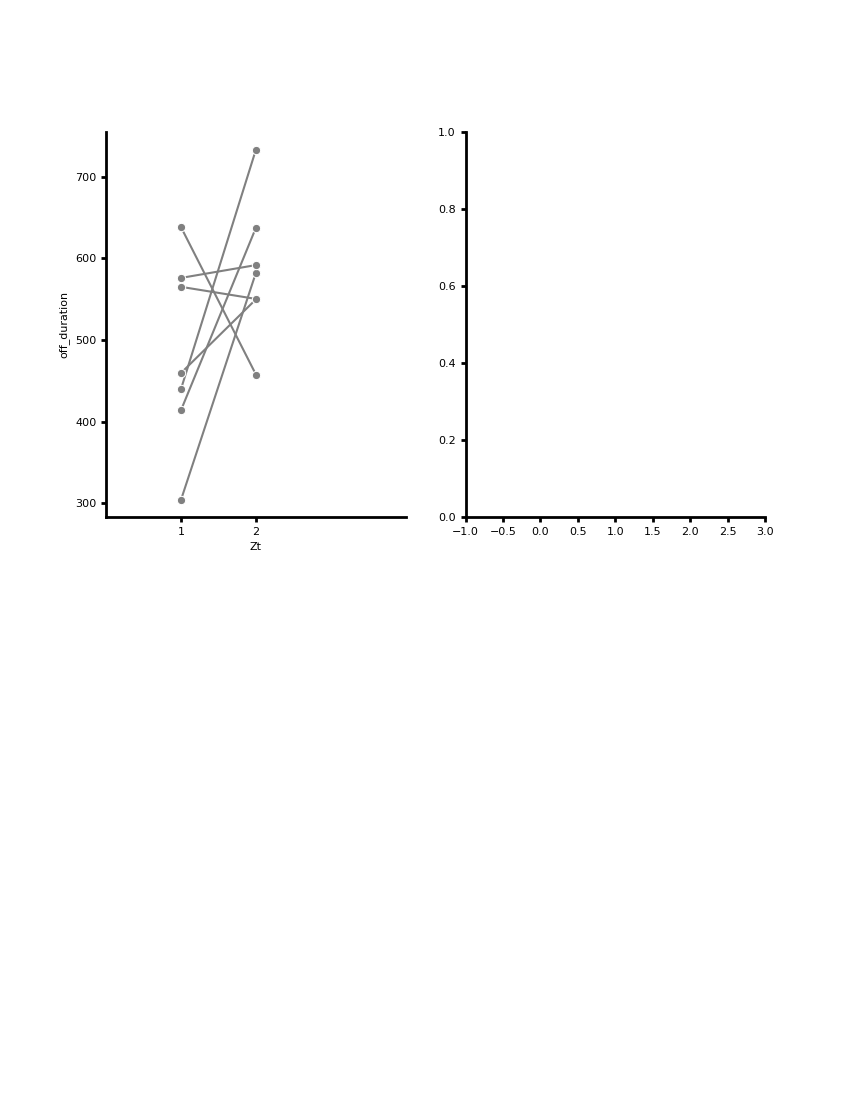

In [73]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# plt.figure(figsize=(8,11))
figure = plotting.Fig()
fig, gs = figure.draw(grid=(2, 2))

for i, grp in enumerate(["sd", "nsd"]):
    data = off_duration[off_duration["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="off_duration",
        hue="sub",
        marker="o",
        palette=["gray"] * 7,
        ax=ax,
        legend=None,
    )
    ax.set_xlim([-1,3])
    # ax.set_ylim([30,450])



### Off periods vs rpls/pbe CCG
- In the hippocampus following PBE/SWR there is a brief period of silence. When plotting the ccg between ripple-stops and off-starts, we see a clear peak around zero. This suggests, off periods detected include post-SWR silence periods too, making it hard to interpret sleep deprivation-induced off-periods in the hippocampus (unlike what was observed in the cortex in Vyazovskiy et al. 2011).
- One possible way to analayze this can be assessing mua activity within these off-periods and see if later in sleep deprivation if neurons more or less silent compared to earlier in sleep deprivation.

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
)

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [15]:
from neuropy.utils.ccg import correlograms

ccg_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    off_durations = sess.off.durations
    off = sess.off.starts
    rpls = sess.ripple.time_slice(*period).stops

    times = np.concatenate([rpls, off])
    ids = np.concatenate([np.ones_like(rpls), 2 * np.ones_like(off)])
    sort_ind = np.argsort(times)

    ccg = correlograms(
        times[sort_ind],
        ids[sort_ind].astype("int"),
        sample_rate=1250,
        bin_size=0.001,
        window_size=0.5,
    )
    ccg_df = ccg_df.append(
        pd.DataFrame({"ccg": ccg[0, 1, :], "time": np.linspace(-0.25, 0.25, 501)}), ignore_index=True
    )


Text(0.5, 0, 'Counts')

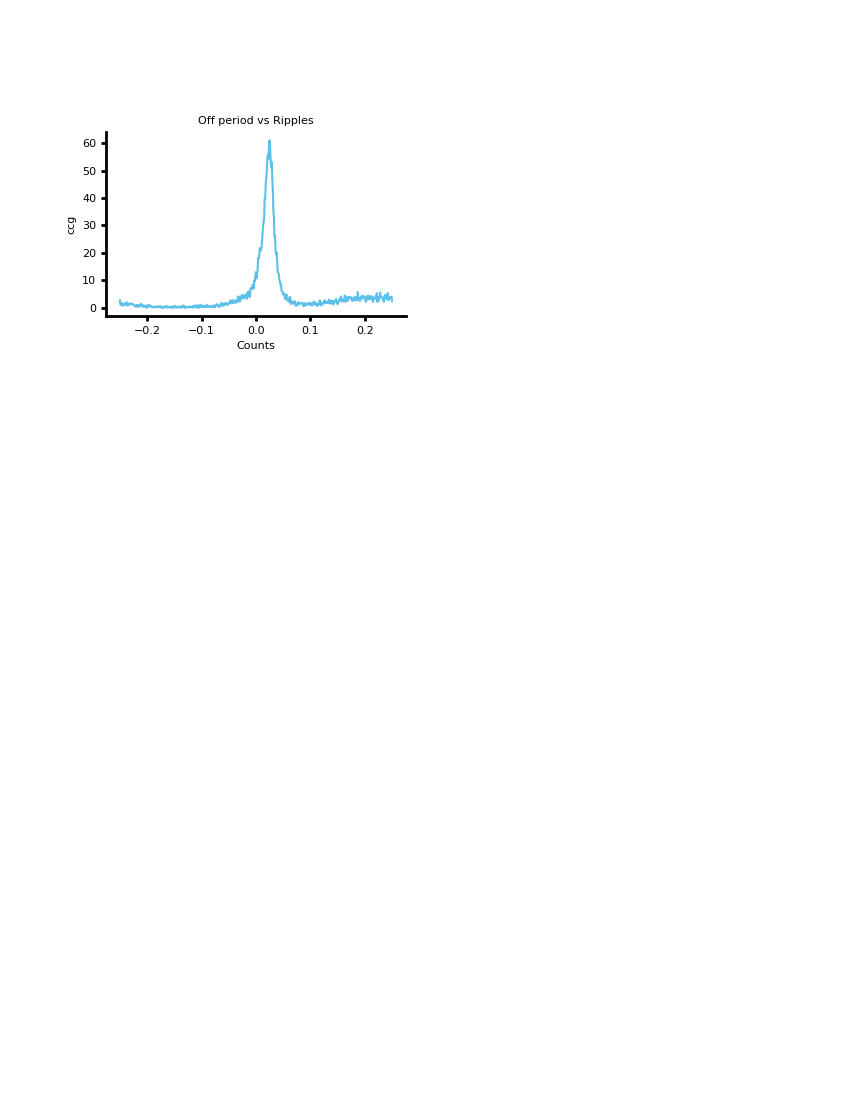

In [21]:
from neuropy import plotting
import seaborn as sns

figure = plotting.Fig()
fig,gs = figure.draw(grid=(4,2))

ax = plt.subplot(gs[0])
sns.lineplot(data=ccg_df,x='time',y='ccg',ax=ax,ci=None)
ax.set_title('Off period vs Ripples')
ax.set_xlabel('Time from end of ripple (ms)')
ax.set_xlabel('Counts')